# Slope and intercept of size abundance relationship - Seasonal and Interannual changes

**** new approach ****

Before this, I would exclude the diazotrophs from this trend becuase they are not found in the Arctic, so they show up as a nan value that creates the whole regression a nan for the Arctic. By taking them out, we solve that problem completely, but that affected the slope of regions that did not have diazotrophs, and any other group that was not found in any other region.. 

SO.... I think I finally figured it out. I instead of making them into nan's I made them into Zeros, and instead of taking just the regular log10, I added a 1 to all of the values so if there are values that are zero's they do not affect the slopes and they just become zeros after the log. 

This solved the problem of having ot have a mask for the diazotrophs, and the slopes look a lot more like they should be looking. 

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os

%matplotlib inline
from glob import glob
import dask
import esmlab
import pop_tools 
from statistics import mean

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Load size abundance slope for the 62 yr period 

In [4]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

In [5]:
variables = [f'{var}' for var in ['ECOSYS_IFRAC']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [6]:
%%time

ds_summer_avg = xr.Dataset()
ds_spring_avg = xr.Dataset()
ds_fall_avg = xr.Dataset()
ds_winter_avg =xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_summer = xr.Dataset()
    ds_spring = xr.Dataset()
    ds_winter = xr.Dataset()
    ds_fall = xr.Dataset()

    file = sorted(glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
    
    winter_indexes = [0,1,-1]
    winter_files = [file[ind] for ind in winter_indexes]
    dsv_winter=xr.open_mfdataset(winter_files, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
        
    dsv_summer=xr.open_mfdataset(file[5:8], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_spring=xr.open_mfdataset(file[2:5], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_fall=xr.open_mfdataset(file[8:11], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_summer = xr.merge((ds_summer, dsv_summer[vv]))
        ds_spring = xr.merge((ds_spring, dsv_spring[vv]))
        ds_winter = xr.merge((ds_winter, dsv_winter[vv]))
        ds_fall = xr.merge((ds_fall, dsv_fall[vv]))
        

    ds_summer = ds_summer.drop([v for v in ds_summer.variables if v not in keep_vars]).squeeze()
    ds_summer = ds_summer.mean(dim='time')
    ds_summer_avg = xr.concat([ds_summer_avg, ds_summer],dim='year')
    
    ds_spring = ds_spring.drop([v for v in ds_spring.variables if v not in keep_vars]).squeeze()
    ds_spring = ds_spring.mean(dim='time')
    ds_spring_avg = xr.concat([ds_spring_avg, ds_spring],dim='year')
    
    ds_winter = ds_winter.drop([v for v in ds_winter.variables if v not in keep_vars]).squeeze()
    ds_winter = ds_winter.mean(dim='time')
    ds_winter_avg = xr.concat([ds_winter_avg, ds_winter],dim='year')
    
    ds_fall = ds_fall.drop([v for v in ds_fall.variables if v not in keep_vars]).squeeze()
    ds_fall = ds_fall.mean(dim='time')
    ds_fall_avg = xr.concat([ds_fall_avg, ds_fall],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 10min 58s, sys: 36.6 s, total: 11min 35s
Wall time: 13min 23s


In [7]:
ypp_surface_62yr = np.load('/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/ypp_surface_62yr_try2.npy')

In [8]:
ypp_surface_62yr.shape

(63, 12, 384, 320, 5)

In [9]:
ypp_surface_62yr[ypp_surface_62yr==0]=np.nan

## Arctic Region : Seasonal slope and intercept

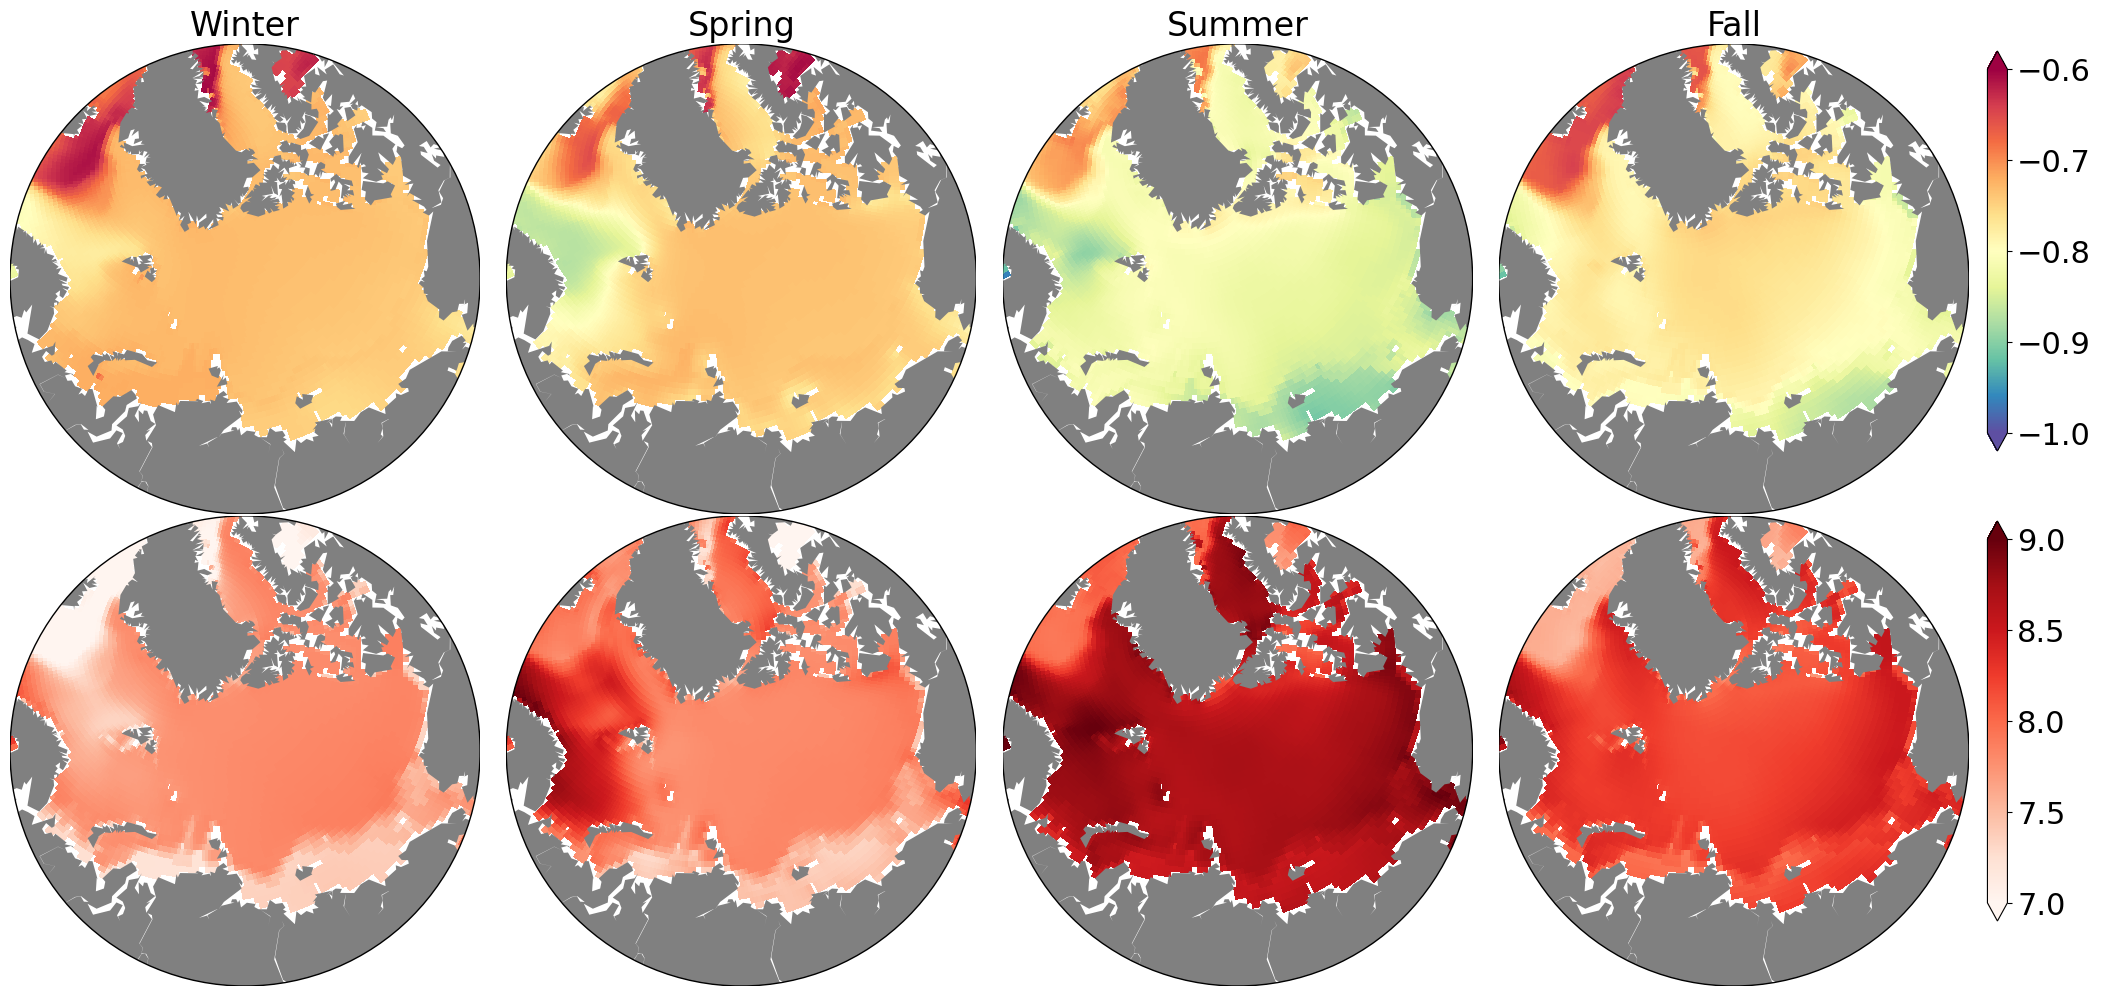

In [10]:
from mpl_toolkits.basemap import Basemap
#lev = np.arange(0, 1, 0.01)
#norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 10))

#### 62 year average!!! 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(2, 4, 1)
lon, lat, winter = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,list(range(2)) + [-1],:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = -1, vmax = -0.6);
ax.set_title('Winter', fontsize =24)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(2, 4, 2)
lon, lat, spring = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,2:5,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = -1, vmax = -0.6);
ax.set_title('Spring', fontsize =24)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(2, 4, 3)
lon, lat, summer = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,5:8,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = -1, vmax = -0.6);
ax.set_title('Summer', fontsize =24)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(2, 4, 4)
lon, lat, fall = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,8:11,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Spectral_r',vmin = -1, vmax = -0.6);
ax.set_title('Fall', fontsize =24)
cbar_ax = fig.add_axes([0.999, 0.55, 0.01, 0.4])
cb = fig.colorbar(cf, shrink=1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=22)

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(2, 4, 5)
lon, lat, winter = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,list(range(2)) + [-1],:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Reds',vmin=7,vmax=9);

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(2, 4, 6)
lon, lat, spring = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,2:5,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Reds',vmin=7,vmax=9);

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(2, 4, 7)
lon, lat, summer = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,5:8,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Reds',vmin=7,vmax=9);

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(2, 4, 8)
lon, lat, fall = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,8:11,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Reds',vmin=7,vmax=9);

cbar_ax = fig.add_axes([0.999, 0.08, 0.01, 0.4])
cb = fig.colorbar(cf, shrink=1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=22)

fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_size_abundance_slope&intercept_quarterly_20yrclim_final.png',dpi=600, bbox_inches='tight')

# Interannual Analysis

### High vs low temperature 

In [11]:
%%time
temp_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc');

CPU times: user 12.1 ms, sys: 6.09 ms, total: 18.2 ms
Wall time: 135 ms


	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset month
			found dataset TLAT
			found dataset TLONG
			found dataset TEMP
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x590000 ext_ncid 0x590000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 2 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 3 name: nlon len: 320 unlimited: 0
		 DIMENSION - dimid: 1 name: month len: 12 unlim

In [12]:
## Calculate climatology for each grid cell
temp_ao_clim = np.nanmean(temp_ds_inter.TEMP,axis=0) # Size (384,320)
temp_ds = np.array(temp_ds_inter.TEMP)

		NC4_inq_var_all: ncid 0x590000 varid 4
		NC4_inq_var_all: ncid 0x590000 varid 4
		NC4_inq_dim: ncid 0x590000 dimid 0
		NC4_inq_dim: ncid 0x590000 dimid 1
		NC4_inq_dim: ncid 0x590000 dimid 2
		NC4_inq_dim: ncid 0x590000 dimid 3
		NC4_inq_dim: ncid 0x590000 dimid 0
		NC4_inq_dim: ncid 0x590000 dimid 1
		NC4_inq_dim: ncid 0x590000 dimid 2
		NC4_inq_dim: ncid 0x590000 dimid 3
		NC4_inq_var_all: ncid 0x590000 varid 4
		NC4_inq_var_all: ncid 0x590000 varid 4
		NC4_inq_dim: ncid 0x590000 dimid 0
		NC4_inq_dim: ncid 0x590000 dimid 1
		NC4_inq_dim: ncid 0x590000 dimid 2
		NC4_inq_dim: ncid 0x590000 dimid 3
		NC4_inq_var_all: ncid 0x590000 varid 4
		NC4_inq_var_all: ncid 0x590000 varid 4
		NC4_inq_dim: ncid 0x590000 dimid 0
		NC4_inq_dim: ncid 0x590000 dimid 1
		NC4_inq_dim: ncid 0x590000 dimid 2
		NC4_inq_dim: ncid 0x590000 dimid 3
		NC4_inq_var_all: ncid 0x590000 varid 4
			NC4_get_vars: var->hdr.name TEMP mem_nc_type 6
		NC4_inq_var_all: ncid 0x590000 varid 4
		NC4_inq_var_all: ncid 0x5900

In [13]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
temp_arctic_anom = np.empty([62,12,384,320]) ; temp_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        temp_arctic_anom[:,:,latitude,longitude] = temp_ds[:,:,latitude,longitude]-temp_ao_clim[:,latitude,longitude]

CPU times: user 1.74 s, sys: 246 ms, total: 1.98 s
Wall time: 2.03 s


In [14]:
%%time
temp_arctic_anom_yearly = np.nanmean(temp_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90 = np.empty([384,320]) ; pcen_90[:] = np.nan
pcen_10 = np.empty([384,320]) ; pcen_10[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10[latitude,longitude]=np.nanpercentile(temp_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 13.1 s, sys: 928 ms, total: 14 s
Wall time: 14.5 s


In [15]:
%%time
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_temp_years_arctic = {}
high_temp_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_temp_years_arctic = multi_dict(2, int)
high_temp_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] < pcen_10[latitude,longitude])
        high_temp_years_arctic[latitude][longitude] = np.where(temp_arctic_anom_yearly[:,latitude,longitude] > pcen_90[latitude,longitude])

CPU times: user 762 ms, sys: 28.2 ms, total: 790 ms
Wall time: 823 ms


In [16]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
cold_years_temp = np.empty([12,384,320]) ; cold_years_temp[:] = np.nan
warm_years_temp = np.empty([12,384,320]) ; warm_years_temp[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        cold_years_temp[:,latitude,longitude] = np.nanmean(temp_ds[low_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        warm_years_temp[:,latitude,longitude] = np.nanmean(temp_ds[high_temp_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

CPU times: user 9.32 s, sys: 21.3 ms, total: 9.34 s
Wall time: 9.6 s


In [17]:
ypp_surface_62yr.shape

(63, 12, 384, 320, 5)

In [18]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
cold_years = np.empty([12,384,320,5]) ; cold_years[:] = np.nan
warm_years = np.empty([12,384,320,5]) ; warm_years[:] = np.nan

for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        cold_years[:,latitude,longitude,:] = np.nanmean(ypp_surface_62yr[low_temp_years_arctic[latitude][longitude],:,latitude,longitude,:],axis=(0,1))
        warm_years[:,latitude,longitude,:] = np.nanmean(ypp_surface_62yr[high_temp_years_arctic[latitude][longitude],:,latitude,longitude,:],axis=(0,1)) 
 

cold_years = ypp_surface_62yr[cold_years_arctic,:,:,:,:] # 1/2 standard deviation 
warm_years = ypp_surface_62yr[warm_years_arctic,:,:,:,:] # 1/2 standard deviation 

### Low vs high ice years 

In [19]:
%%time
ECOSYS_IFRAC_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc');

CPU times: user 19.4 ms, sys: 43.3 ms, total: 62.7 ms
Wall time: 260 ms


	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset month
			found dataset TLAT
			found dataset TLONG
			found dataset ECOSYS_IFRAC
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x660000 ext_ncid 0x660000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFRAC_ds_inter_surface.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 2 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 3 name: nlon len: 320 unlimited: 0
		 DIMENSION - di

In [20]:
## Calculate climatology for each grid cell
ice_ao_clim = np.nanmean(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC,axis=0) # Size (12,384,320)
ECOSYS_IFRAC_ds = np.array(ECOSYS_IFRAC_ds_inter.ECOSYS_IFRAC)

		NC4_inq_var_all: ncid 0x660000 varid 4
		NC4_inq_var_all: ncid 0x660000 varid 4
		NC4_inq_dim: ncid 0x660000 dimid 0
		NC4_inq_dim: ncid 0x660000 dimid 1
		NC4_inq_dim: ncid 0x660000 dimid 2
		NC4_inq_dim: ncid 0x660000 dimid 3
		NC4_inq_dim: ncid 0x660000 dimid 0
		NC4_inq_dim: ncid 0x660000 dimid 1
		NC4_inq_dim: ncid 0x660000 dimid 2
		NC4_inq_dim: ncid 0x660000 dimid 3
		NC4_inq_var_all: ncid 0x660000 varid 4
		NC4_inq_var_all: ncid 0x660000 varid 4
		NC4_inq_dim: ncid 0x660000 dimid 0
		NC4_inq_dim: ncid 0x660000 dimid 1
		NC4_inq_dim: ncid 0x660000 dimid 2
		NC4_inq_dim: ncid 0x660000 dimid 3
		NC4_inq_var_all: ncid 0x660000 varid 4
		NC4_inq_var_all: ncid 0x660000 varid 4
		NC4_inq_dim: ncid 0x660000 dimid 0
		NC4_inq_dim: ncid 0x660000 dimid 1
		NC4_inq_dim: ncid 0x660000 dimid 2
		NC4_inq_dim: ncid 0x660000 dimid 3
		NC4_inq_var_all: ncid 0x660000 varid 4
			NC4_get_vars: var->hdr.name ECOSYS_IFRAC mem_nc_type 6
		NC4_inq_var_all: ncid 0x660000 varid 4
		NC4_inq_var_all: nci

In [21]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
ice_arctic_anom = np.empty([62,12,384,320]) ; ice_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        ice_arctic_anom[:,:,latitude,longitude] = ECOSYS_IFRAC_ds[:,:,latitude,longitude]-ice_ao_clim[:,latitude,longitude]

CPU times: user 1.94 s, sys: 264 ms, total: 2.2 s
Wall time: 2.24 s


In [22]:
ice_arctic_anom_yearly = np.nanmean(ice_arctic_anom,axis=1) # size is now (62,180,360)

# Create empty arrays filled with NaN's 
pcen_90_ice = np.empty([384,320]) ; pcen_90_ice[:] = np.nan
pcen_10_ice = np.empty([384,320]) ; pcen_10_ice[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_ice[latitude,longitude]=np.nanpercentile(ice_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

In [23]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_ice_years_arctic = {}
high_ice_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_ice_years_arctic = multi_dict(2, int)
high_ice_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] < pcen_10_ice[latitude,longitude])
        high_ice_years_arctic[latitude][longitude] = np.where(ice_arctic_anom_yearly[:,latitude,longitude] > pcen_90_ice[latitude,longitude])

In [24]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_ice_years_temp = np.empty([12,384,320]) ; low_ice_years_temp[:] = np.nan
high_ice_years_temp = np.empty([12,384,320]) ; high_ice_years_temp[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1)) 

In [25]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values.
low_ice_years = np.empty([12,384,320,5]) ; low_ice_years[:] = np.nan
high_ice_years = np.empty([12,384,320,5]) ; high_ice_years[:] = np.nan

for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_ice_years[:,latitude,longitude,:] = np.nanmean(ypp_surface_62yr[low_ice_years_arctic[latitude][longitude],:,latitude,longitude,:],axis=(0,1))
        high_ice_years[:,latitude,longitude,:] = np.nanmean(ypp_surface_62yr[high_ice_years_arctic[latitude][longitude],:,latitude,longitude,:],axis=(0,1)) 


CPU times: user 10.3 s, sys: 489 ms, total: 10.8 s
Wall time: 16 s


low_ice_years = ypp_surface_62yr[low_ice_years_arctic,:,:,:,:] # 1/2 standard deviation 
high_ice_years = ypp_surface_62yr[high_ice_years_arctic,:,:,:,:] # 1/2 standard deviation 

### Low vs high nutrient years

In [26]:
%%time
NO3_ds_inter = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc');

CPU times: user 8.38 ms, sys: 9.9 ms, total: 18.3 ms
Wall time: 164 ms


	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset nlat
			found dataset nlon
			found dataset month
			found dataset TLAT
			found dataset TLONG
			found dataset NO3
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x710000 ext_ncid 0x710000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/nc_files/NO3_ds_inter_surface.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 62 unlimited: 0
		 DIMENSION - dimid: 2 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 3 name: nlon len: 320 unlimited: 0
		 DIMENSION - dimid: 1 name: month len: 12 unlimited

In [27]:
%%time
## Calculate climatology for each grid cell
no3_ao_clim = np.nanmean(NO3_ds_inter.NO3,axis=0) # Size (12,384,320)

		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_dim: ncid 0x710000 dimid 0
		NC4_inq_dim: ncid 0x710000 dimid 1
		NC4_inq_dim: ncid 0x710000 dimid 2
		NC4_inq_dim: ncid 0x710000 dimid 3
		NC4_inq_dim: ncid 0x710000 dimid 0
		NC4_inq_dim: ncid 0x710000 dimid 1
		NC4_inq_dim: ncid 0x710000 dimid 2
		NC4_inq_dim: ncid 0x710000 dimid 3
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_dim: ncid 0x710000 dimid 0
		NC4_inq_dim: ncid 0x710000 dimid 1
		NC4_inq_dim: ncid 0x710000 dimid 2
		NC4_inq_dim: ncid 0x710000 dimid 3
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_dim: ncid 0x710000 dimid 0
		NC4_inq_dim: ncid 0x710000 dimid 1
		NC4_inq_dim: ncid 0x710000 dimid 2
		NC4_inq_dim: ncid 0x710000 dimid 3
		NC4_inq_var_all: ncid 0x710000 varid 4
			NC4_get_vars: var->hdr.name NO3 mem_nc_type 6
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_var_all: ncid 0x71000

CPU times: user 564 ms, sys: 1.45 s, total: 2.01 s
Wall time: 2.32 s


In [28]:
NO3_ds = np.array(NO3_ds_inter.NO3)

		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_dim: ncid 0x710000 dimid 0
		NC4_inq_dim: ncid 0x710000 dimid 1
		NC4_inq_dim: ncid 0x710000 dimid 2
		NC4_inq_dim: ncid 0x710000 dimid 3
		NC4_inq_dim: ncid 0x710000 dimid 0
		NC4_inq_dim: ncid 0x710000 dimid 1
		NC4_inq_dim: ncid 0x710000 dimid 2
		NC4_inq_dim: ncid 0x710000 dimid 3
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_dim: ncid 0x710000 dimid 0
		NC4_inq_dim: ncid 0x710000 dimid 1
		NC4_inq_dim: ncid 0x710000 dimid 2
		NC4_inq_dim: ncid 0x710000 dimid 3
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_dim: ncid 0x710000 dimid 0
		NC4_inq_dim: ncid 0x710000 dimid 1
		NC4_inq_dim: ncid 0x710000 dimid 2
		NC4_inq_dim: ncid 0x710000 dimid 3
		NC4_inq_var_all: ncid 0x710000 varid 4
			NC4_get_vars: var->hdr.name NO3 mem_nc_type 6
		NC4_inq_var_all: ncid 0x710000 varid 4
		NC4_inq_var_all: ncid 0x71000

In [29]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
no3_arctic_anom = np.empty([62,12,384,320]) ; no3_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        no3_arctic_anom[:,:,latitude,longitude] = NO3_ds[:,:,latitude,longitude]-no3_ao_clim[:,latitude,longitude]

CPU times: user 1.64 s, sys: 251 ms, total: 1.89 s
Wall time: 1.9 s


In [30]:
%%time
no3_arctic_anom_yearly = np.nanmean(no3_arctic_anom,axis=1) # size is now (62,384,320)

# Create empty arrays filled with NaN's 
pcen_90_no3 = np.empty([384,320]) ; pcen_90_no3[:] = np.nan
pcen_10_no3 = np.empty([384,320]) ; pcen_10_no3[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
    # index of array entry nearest to percentile value
        pcen_90_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],90,interpolation='nearest')
        pcen_10_no3[latitude,longitude]=np.nanpercentile(no3_arctic_anom_yearly[:,latitude,longitude],10,interpolation='nearest')

CPU times: user 12.9 s, sys: 882 ms, total: 13.8 s
Wall time: 14.1 s


In [31]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_no3_years_arctic = {}
high_no3_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_no3_years_arctic = multi_dict(2, int)
high_no3_years_arctic = multi_dict(2, int)
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] < pcen_10_no3[latitude,longitude])
        high_no3_years_arctic[latitude][longitude] = np.where(no3_arctic_anom_yearly[:,latitude,longitude] > pcen_90_no3[latitude,longitude])

In [32]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years = np.empty([12,384,320,5]) ; low_no3_years[:] = np.nan
high_no3_years = np.empty([12,384,320,5]) ; high_no3_years[:] = np.nan
for latitude in np.arange(0,384,1):
    for longitude in np.arange(0,320,1):
        low_no3_years[:,latitude,longitude,:] = np.nanmean(ypp_surface_62yr[low_no3_years_arctic[latitude][longitude],:,latitude,longitude,:],axis=(0,1))
        high_no3_years[:,latitude,longitude,:] = np.nanmean(ypp_surface_62yr[high_no3_years_arctic[latitude][longitude],:,latitude,longitude,:],axis=(0,1))

low_no3_years = ypp_surface_62yr[low_no3_years_arctic,:,:,:,:] # 1/2 standard deviation 
high_no3_years = ypp_surface_62yr[high_no3_years_arctic,:,:,:,:] # 1/2 standard deviation 

## Ice Fraction

In [33]:
ice_frac_summer = np.array(ds_summer_avg.ECOSYS_IFRAC)
ice_frac_winter = np.array(ds_winter_avg.ECOSYS_IFRAC)
ice_frac_fall = np.array(ds_fall_avg.ECOSYS_IFRAC)
ice_frac_spring = np.array(ds_spring_avg.ECOSYS_IFRAC)

	NC4_close: ncid 0x590000
			nc4_close_hdf5_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc abort 0
			nc4_rec_grp_HDF5_del: grp->name /
			closing HDF5 dataset 360287970189639680
			closing HDF5 dataset 360287970189639683
			closing HDF5 dataset 360287970189639684
			closing HDF5 dataset 360287970189639687
			closing HDF5 dataset 360287970189639690
			nc4_close_netcdf4_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/temp_ds_inter_surface.nc abort 0
			nc4_rec_grp_del: grp->name /
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
			att_free: name missing_value 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
			att_free: name missing_value 
			att_free: name _FillValue 
			att_free: name description 
			att_free: name units 
			att_free: name coordinates 
	NC4_close: ncid 0x660000
			nc4_close_hdf5_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/nc_files/ECOSYS_IFR

In [34]:
# This is loading the low and high temp, no3 and ice years when averging the whole Arctic... 
# I tried to do it grid by grid, but ice fraction works better when you average throughout the whole Arctic. 
high_ice_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_ice_years_arctic.npy')
low_ice_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_ice_years_arctic.npy')

high_no3_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_no3_years_arctic.npy')
low_no3_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_no3_years_arctic.npy')

high_temp_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_temp_years_arctic.npy')
low_temp_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_temp_years_arctic.npy')

In [35]:
## NO3
low_no3_years_summer_ice = ice_frac_summer[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_summer_ice = ice_frac_summer[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_spring_ice = ice_frac_spring[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_spring_ice= ice_frac_spring[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_fall_ice = ice_frac_fall[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_fall_ice = ice_frac_fall[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_winter_ice = ice_frac_winter[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_winter_ice = ice_frac_winter[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

## ice
low_ice_years_summer_ice = ice_frac_summer[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_summer_ice = ice_frac_summer[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_spring_ice = ice_frac_spring[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_spring_ice= ice_frac_spring[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_fall_ice = ice_frac_fall[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_fall_ice = ice_frac_fall[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_winter_ice = ice_frac_winter[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_winter_ice = ice_frac_winter[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

## temperature
low_temp_years_summer_ice = ice_frac_summer[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_summer_ice = ice_frac_summer[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_spring_ice = ice_frac_spring[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_spring_ice= ice_frac_spring[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_fall_ice = ice_frac_fall[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_fall_ice = ice_frac_fall[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_winter_ice = ice_frac_winter[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_winter_ice = ice_frac_winter[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

In [37]:
warm_years.shape

(12, 384, 320, 5)

## Publication ready figure

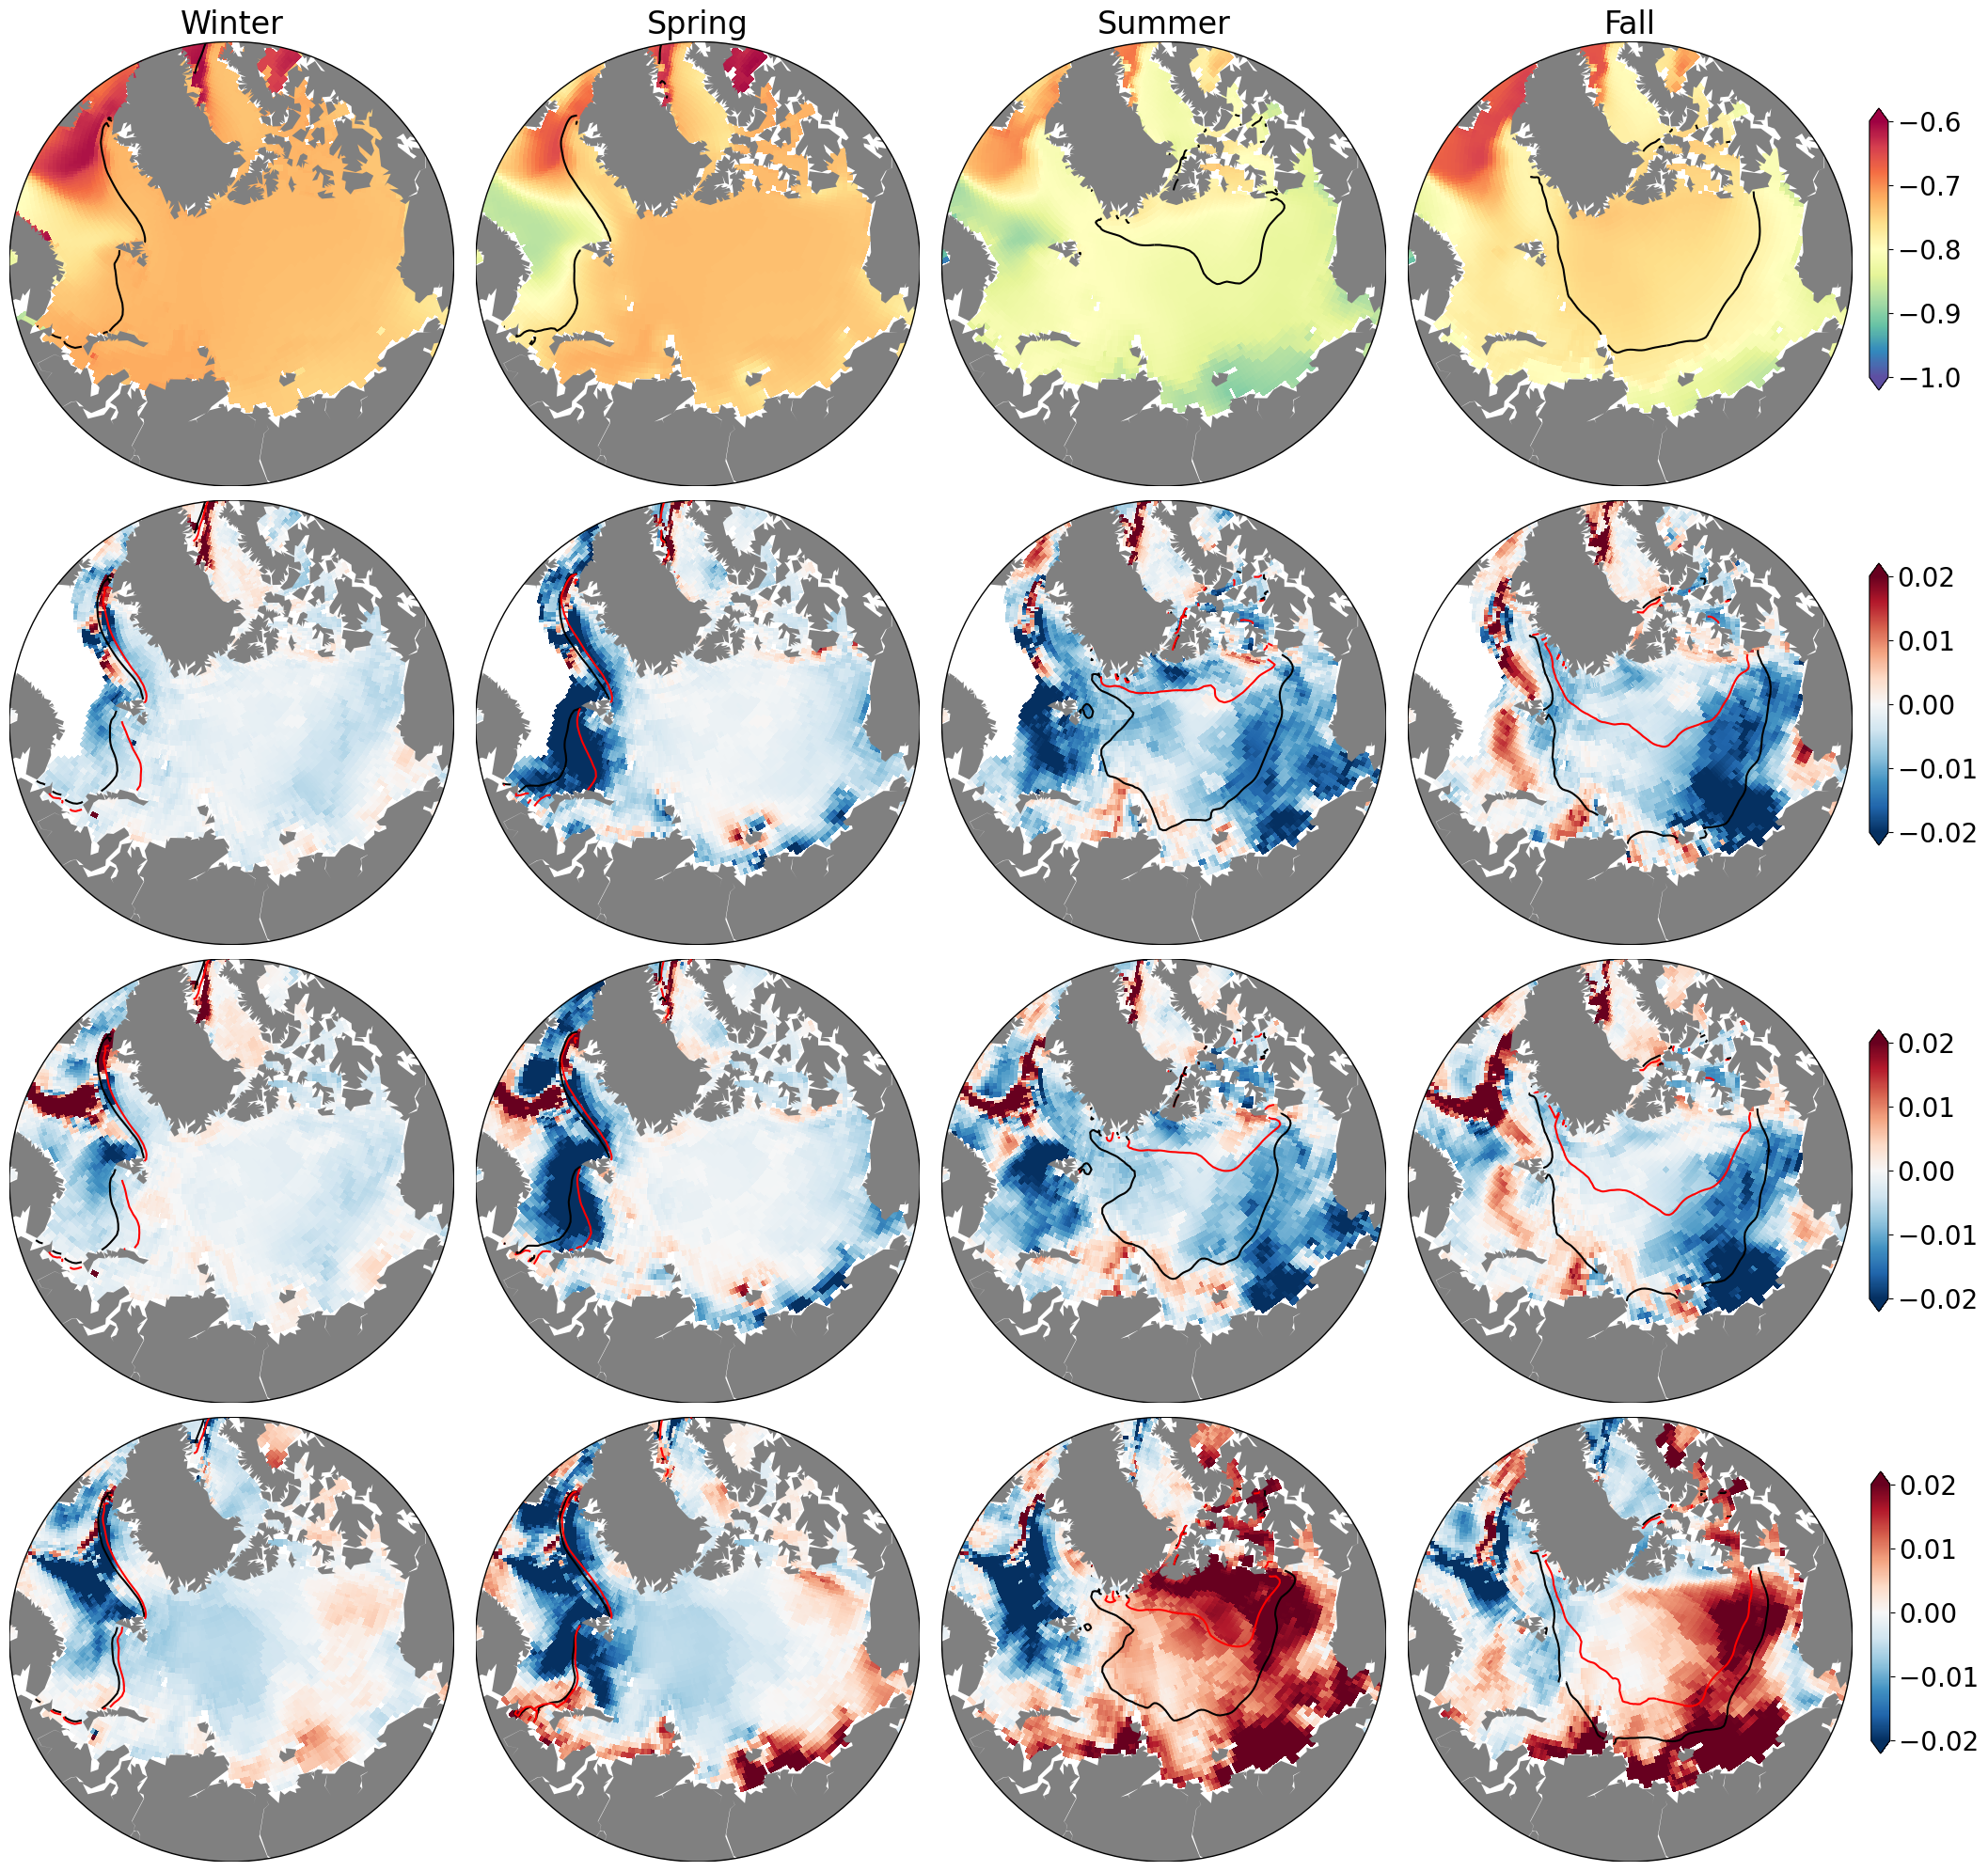

In [41]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 1, 0.01)
norm  = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))

# ------------------------------------------------
########## Seasonal Changes #############
# ------------------------------------------------
#  62-year average 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ypp_surface_62yr[:,list(range(2)) + [-1],:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = -1, vmax = -0.6);
tlon, tlat, winter_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_winter_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');
ax.set_title('Winter', fontsize =24)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(4, 4, 2)
lon, lat, spring = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ypp_surface_62yr[:,2:5,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = -1, vmax = -0.6);
tlon, tlat, spring_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_spring_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');
ax.set_title('Spring', fontsize =24)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 3)
lon, lat, summer = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ypp_surface_62yr[:,5:8,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = -1, vmax = -0.6);
tlon, tlat, summer_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_summer_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');
ax.set_title('Summer', fontsize =24)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 4)
lon, lat, fall = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ypp_surface_62yr[:,8:11,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Spectral_r',vmin = -1, vmax = -0.6);
tlon, tlat, fall_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_fall_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
cbar_ax = fig.add_axes([0.999, 0.79, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel('Phytoplankton biomass ($\mu$gC m$^{-3}$)', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Fall', fontsize =24)

# ------------------------------------------------
########## Interannual differences #############
# ------------------------------------------------
vminn=-0.02
vmaxx=0.02

# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 9)
winter_temp_diff = ((np.nanmean(warm_years[list(range(2)) + [-1],:,:,0], axis=(0))-np.nanmean(cold_years[list(range(2)) + [-1],:,:,0], axis=(0))))
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 10)
spring_temp_diff = ((np.nanmean(warm_years[2:5,:,:,0], axis=(0))-np.nanmean(cold_years[2:5,:,:,0], axis=(0))))
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 11)
summer_temp_diff = ((np.nanmean(warm_years[5:8,:,:,0], axis=(0))-np.nanmean(cold_years[5:8,:,:,0], axis=(0))))
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 12)
fall_temp_diff = ((np.nanmean(warm_years[8:11,:,:,0], axis=(0))-np.nanmean(cold_years[8:11,:,:,0], axis=(0))))
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low temperature)', fontsize=20)
cb.ax.tick_params(labelsize=20)

## Ice Fraction

# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 5)
winter_ice_diff = np.nanmean(low_ice_years[list(range(2)) + [-1],:,:,0], axis=(0))-np.nanmean(high_ice_years[list(range(2)) + [-1],:,:,0], axis=(0))
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low ice years 

# Spring, % difference of catch from high and low ice fraction years. 
ax = fig.add_subplot(4, 4, 6)
spring_ice_diff = np.nanmean(low_ice_years[2:5,:,:,0], axis=(0))-np.nanmean(high_ice_years[2:5,:,:,0], axis=(0))
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low ice years 

# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 7)
summer_ice_diff = np.nanmean(low_ice_years[5:8,:,:,0], axis=(0))-np.nanmean(high_ice_years[5:8,:,:,0], axis=(0))
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# Fall, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 8)
fall_ice_diff = np.nanmean(low_ice_years[8:11,:,:,0], axis=(0))-np.nanmean(high_ice_years[8:11,:,:,0], axis=(0))
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low ice years 
cbar_ax = fig.add_axes([0.999, 0.548, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (low-high ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)


# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = np.nanmean(high_no3_years[list(range(2)) + [-1],:,:,0], axis=(0))-np.nanmean(low_no3_years[list(range(2)) + [-1],:,:,0], axis=(0))
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
#cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=ax)

# Spring, % difference of catch from high and low NO$_3$ years. 
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = np.nanmean(high_no3_years[2:5,:,:,0], axis=(0))-np.nanmean(low_no3_years[2:5,:,:,0], axis=(0))
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
#cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', ax=ax)

# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = np.nanmean(high_no3_years[5:8,:,:,0], axis=(0))-np.nanmean(low_no3_years[5:8,:,:,0], axis=(0))
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
#cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', ax=ax)

# Fall, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = np.nanmean(high_no3_years[8:11,:,:,0], axis=(0))-np.nanmean(low_no3_years[8:11,:,:,0], axis=(0))
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn, vmax=vmaxx);
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
cbar_ax = fig.add_axes([0.9999, 0.065, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/quarterly_size_abundance_slope_interannual_final_cb.png',dpi=600, bbox_inches='tight')

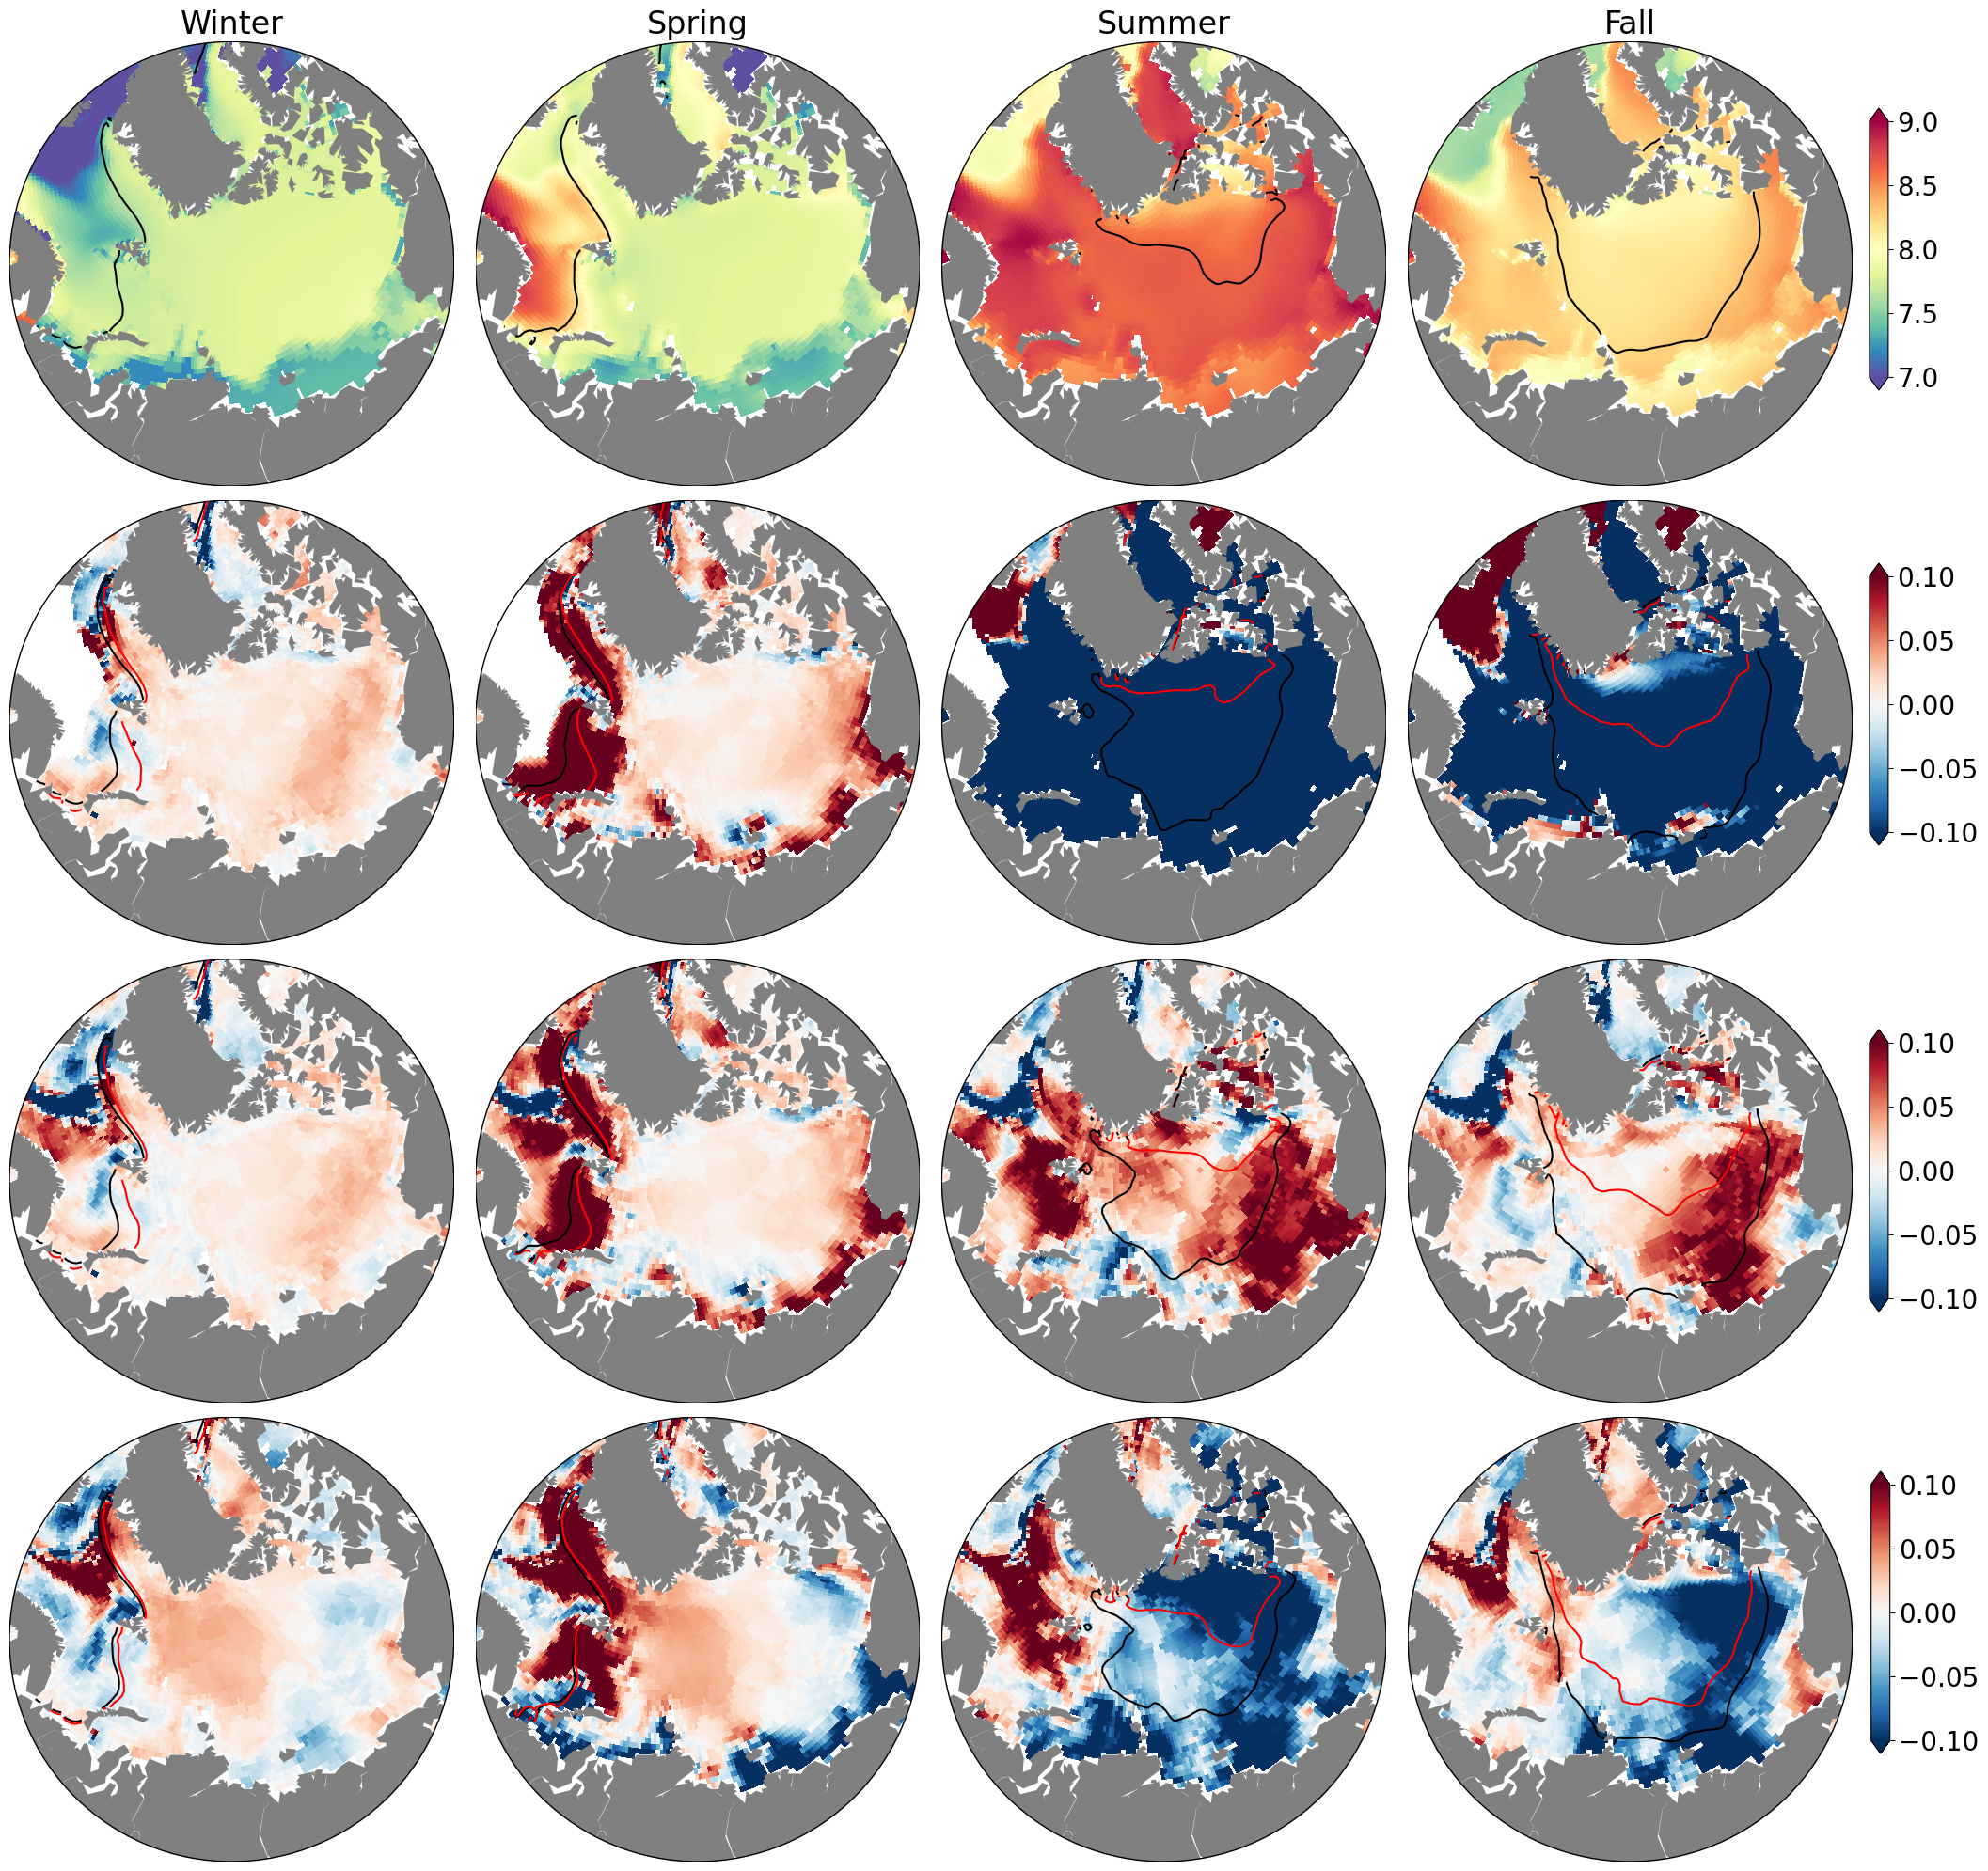

In [40]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))

# ------------------------------------------------
########## Seasonal Changes #############
# ------------------------------------------------
#  62-year average  

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ypp_surface_62yr[:,list(range(2)) + [-1],:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 7, vmax = 9);
tlon, tlat, winter_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_winter_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');

ax.set_title('Winter', fontsize =24)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(4, 4, 2)
lon, lat, spring = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ypp_surface_62yr[:,2:5,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 7, vmax = 9);
tlon, tlat, spring_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_spring_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');

ax.set_title('Spring', fontsize =24)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 3)
lon, lat, summer = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ypp_surface_62yr[:,5:8,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 7, vmax = 9);
tlon, tlat, summer_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_summer_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');

ax.set_title('Summer', fontsize =24)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 4)
lon, lat, fall = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ypp_surface_62yr[:,8:11,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Spectral_r',vmin = 7, vmax = 9);
tlon, tlat, fall_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_fall_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
cbar_ax = fig.add_axes([0.999, 0.79, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
ax.set_title('Fall', fontsize =24)

# ------------------------------------------------
########## Interannual Differences #############
# ------------------------------------------------
vminn=-0.1
vmaxx=0.1
# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 9)
winter_temp_diff = ((np.nanmean(warm_years[list(range(2)) + [-1],:,:,1], axis=(0))-np.nanmean(cold_years[list(range(2)) + [-1],:,:,1], axis=(0))))
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_winter_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 10)
spring_temp_diff = ((np.nanmean(warm_years[2:5,:,:,1], axis=(0))-np.nanmean(cold_years[2:5,:,:,1], axis=(0))))
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_spring_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 11)
summer_temp_diff = ((np.nanmean(warm_years[5:8,:,:,1], axis=(0))-np.nanmean(cold_years[5:8,:,:,1], axis=(0))))
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_summer_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 12)
fall_temp_diff = ((np.nanmean(warm_years[8:11,:,:,1], axis=(0))-np.nanmean(cold_years[8:11,:,:,1], axis=(0))))
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_fall_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low temperature)', fontsize=20)
cb.ax.tick_params(labelsize=20)

## Ice Fraction

# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 5)
winter_ice_diff = ((np.nanmean(low_ice_years[list(range(2)) + [-1],:,:,1], axis=(0))-np.nanmean(high_ice_years[list(range(2)) + [-1],:,:,1], axis=(0))))
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_winter_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# Spring, % difference of catch from high and low ice fraction years. 
ax = fig.add_subplot(4, 4, 6)
spring_ice_diff = ((np.nanmean(low_ice_years[2:5,:,:,1], axis=(0))-np.nanmean(high_ice_years[2:5,:,:,1], axis=(0))))
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_spring_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 7)
summer_ice_diff = ((np.nanmean(low_ice_years[5:8,:,:,1], axis=(0,1,2))-np.nanmean(high_ice_years[5:8,:,:,1], axis=(0))))
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_summer_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# Fall, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 8)
fall_ice_diff = ((np.nanmean(low_ice_years[8:11,:,:,1], axis=(0,1,2))-np.nanmean(high_ice_years[8:11,:,:,1], axis=(0))))
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_fall_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low ice years 
cbar_ax = fig.add_axes([0.999, 0.548, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (low-high ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)


# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = ((np.nanmean(high_no3_years[list(range(2)) + [-1],:,:,1], axis=(0))-np.nanmean(low_no3_years[list(range(2)) + [-1],:,:,1], axis=(0))))
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_winter_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# Spring, % difference of catch from high and low NO$_3$ years. 
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = ((np.nanmean(high_no3_years[2:5,:,:,1], axis=(0))-np.nanmean(low_no3_years[2:5,:,:,1], axis=(0))))
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_spring_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low no3 years 


# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = ((np.nanmean(high_no3_years[5:8,:,:,1], axis=(0))-np.nanmean(low_no3_years[5:8,:,:,1], axis=(0))))
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_summer_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low no3 years 


# Fall, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = ((np.nanmean(high_no3_years[8:11,:,:,1], axis=(0))-np.nanmean(low_no3_years[8:11,:,:,1], axis=(0))))
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_fall_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
cbar_ax = fig.add_axes([0.9999, 0.065, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/quarterly_size_abundance_intercept_interannual_final_absdiff.png',dpi=600, bbox_inches='tight')